In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import akshare as ak  # 用于获取股票数据
from docx import Document
from docx.shared import Inches
from datetime import datetime
import os
import time

In [145]:
# 获取A股002050的数据
def get_stock_data(stock_code, start, end):
    data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start, end_date=end, adjust="qfq")
    data.set_index("日期", inplace=True)  # 将日期列设置为索引
    print(len(data),data)
    return data[["收盘"]]  # 只获取收盘价

In [146]:
# 数据准备
stock_code = "000801"
price_data = get_stock_data(stock_code,"20100101","20250213")
scaler = MinMaxScaler(feature_range=(0, 1))  # 归一化数据到 [0, 1] 范围
scaled_data = scaler.fit_transform(price_data)  # 归一化数据

3609               股票代码     开盘     收盘     最高     最低     成交量           成交额    振幅  \
日期                                                                           
2010-01-04  000801   2.52   2.51   2.61   2.49   19753  2.341157e+07  4.76   
2010-01-05  000801   2.52   2.55   2.55   2.46   20841  2.429201e+07  3.59   
2010-01-06  000801   2.55   2.59   2.63   2.51   33493  4.024513e+07  4.71   
2010-01-07  000801   2.55   2.46   2.62   2.44   24625  2.879462e+07  6.95   
2010-01-08  000801   2.44   2.51   2.51   2.43   10112  1.166170e+07  3.25   
...            ...    ...    ...    ...    ...     ...           ...   ...   
2025-02-07  000801  15.10  15.90  16.28  15.05  933367  1.475245e+09  8.08   
2025-02-10  000801  15.80  16.16  16.61  15.71  830676  1.354937e+09  5.66   
2025-02-11  000801  15.99  16.18  16.88  15.60  836754  1.349668e+09  7.92   
2025-02-12  000801  16.06  16.48  16.59  15.90  779167  1.277977e+09  4.26   
2025-02-13  000801  16.80  16.14  16.90  16.14  793287  1.3

In [127]:
# 创建序列数据
def create_sequences(data, seq_length=60):  # 使用前60天的数据
    X, y = [], []
    for i in range(len(data) - seq_length):  # 遍历数据集，构建滑动窗口
        X.append(data[i:i + seq_length])  # 输入序列
        y.append(data[i + seq_length])  # 目标值
    return np.array(X), np.array(y)

In [128]:
seq_length = 60  # 更新序列长度为60
X, y = create_sequences(scaled_data, seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # 调整形状以适应 LSTM 输入要求

In [129]:
# 划分训练集和测试集
train_size = int(len(X) * 0.8)  # 80% 数据用于训练，20% 用于测试
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [130]:
# 构建LSTM模型
model = Sequential([
    Input(shape=(seq_length, 1)),  # 正确的输入层
    LSTM(50, return_sequences=True),  # 第一层 LSTM，返回完整序列
    LSTM(50),  # 第二层 LSTM，输出最终状态
    Dense(1)  # 输出层，预测单个值
])
model.compile(optimizer='adam', loss='mse')  # 使用 Adam 优化器，均方误差损失函数

In [132]:
# 训练模型
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 7.9487e-04 - val_loss: 0.0015
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.1604e-04 - val_loss: 0.0026
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.7855e-04 - val_loss: 0.0012
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 4.7305e-04 - val_loss: 0.0012
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 5.4604e-04 - val_loss: 0.0010
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - loss: 4.8117e-04 - val_loss: 8.4975e-04
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ -14s -77977us/step - loss: 4.3090e-04 - val_loss: 7.6159e-04
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.1424e-04 - val_loss: 8.3260e-04
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.3738e-04 - val_loss: 0.0011
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.0524e-04 - val_loss: 7.2462e-04


In [133]:
# 1️⃣ 获取当前时间作为文件名前缀
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # 格式：YYYYMMDD_HHMMSS
output_file = f"out_data/{current_time}_lstm.docx"
# 2️⃣ 创建 Word 文档
doc = Document()
# 3️⃣ 添加文本（今天的日期）
today = datetime.today().date()
doc.add_paragraph(f"{today} -------- {stock_code}")

In [134]:
# 预测
predicted = model.predict(X_test)  # 生成预测值
predicted = scaler.inverse_transform(predicted)  # 反归一化以获得真实价格
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # 反归一化真实价格

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


In [135]:
#最后一天价格
last_date = price_data.index[-1]
last_predicted_price = predicted[-1][0]
last_real_price = price_data.iloc[-1]["收盘"]
print(last_date,last_real_price,last_predicted_price)

2025-02-13 16.14 16.986801


In [136]:
# 预测接下来10天的价格
future_prices = []
future_dates = pd.date_range(start=last_date, periods=11, freq='B')[1:]  # 获取未来10个交易日的日期
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)  # 取最后60天数据作为输入

for i in range(10):
    next_day_scaled = model.predict(last_sequence)  # 预测未来一天价格（归一化后）
    next_day_price = scaler.inverse_transform(next_day_scaled)[0][0]  # 反归一化得到实际价格
    future_prices.append(next_day_price)
    
    # 更新 last_sequence 以预测下一天
    new_sequence = np.append(last_sequence[:, 1:, :], next_day_scaled.reshape(1, 1, 1), axis=1)
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


图表已保存到：temp_png/000801_price_prediction.png


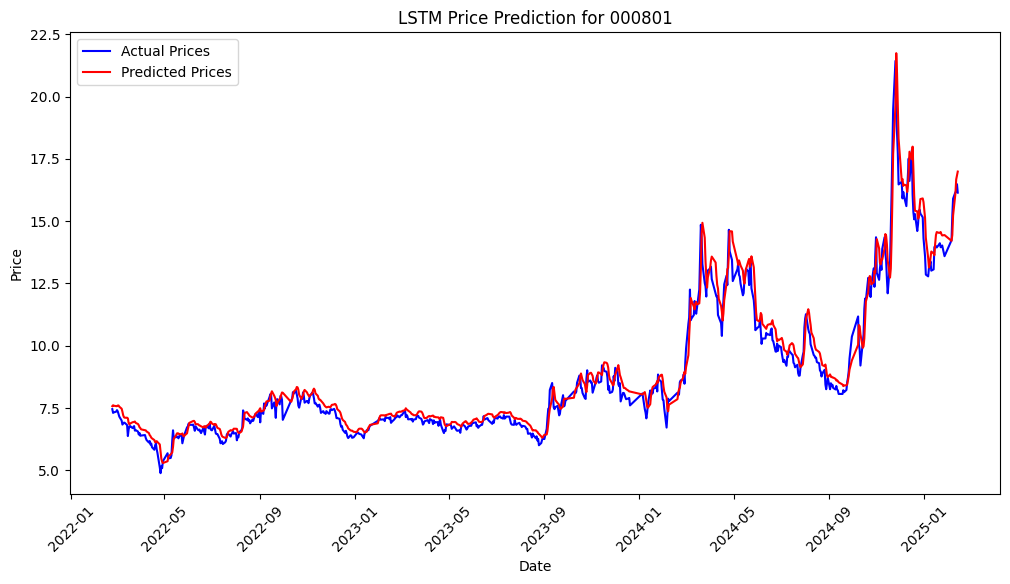

In [137]:

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(price_data.index[-len(y_test_actual):], y_test_actual, label='Actual Prices', color='blue')  # 绘制实际价格
plt.plot(price_data.index[-len(predicted):], predicted, label='Predicted Prices', color='red')  # 绘制预测价格
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f'LSTM Price Prediction for {stock_code}')

# 保存图表到本地
output_path = f"temp_png/{stock_code}_price_prediction.png"  # 图片保存路径
plt.savefig(output_path, bbox_inches='tight', dpi=300)  # 保存为 PNG 文件
print(f"图表已保存到：{output_path}")

# 5️⃣ 插入图片到 Word 文档
doc.add_paragraph(f"{stock_code}拟合曲线：")
doc.add_picture(output_path, width=Inches(8))  # 插入图片并调整宽度

plt.show()

In [139]:
# 输出预测结果
print(f"------------------:{stock_code}")
last_day_dect= f"最后一天的日期: {last_date}, 收盘价格: {last_real_price}, 预测价格: {last_predicted_price}"
print(last_day_dect)
doc.add_paragraph(last_day_dect)
for i in range(10):
    str = f"预测日期: {future_dates[i]}, 预测价格: {future_prices[i]}"
    print(str)
    doc.add_paragraph(str)

------------------:000801
最后一天的日期: 2025-02-13, 收盘价格: 16.14, 预测价格: 16.986801147460938
预测日期: 2025-02-14 00:00:00, 预测价格: 16.789247512817383
预测日期: 2025-02-17 00:00:00, 预测价格: 17.046892166137695
预测日期: 2025-02-18 00:00:00, 预测价格: 17.38648796081543
预测日期: 2025-02-19 00:00:00, 预测价格: 17.761972427368164
预测日期: 2025-02-20 00:00:00, 预测价格: 18.16162872314453
预测日期: 2025-02-21 00:00:00, 预测价格: 18.57868003845215
预测日期: 2025-02-24 00:00:00, 预测价格: 19.007875442504883
预测日期: 2025-02-25 00:00:00, 预测价格: 19.445100784301758
预测日期: 2025-02-26 00:00:00, 预测价格: 19.887266159057617
预测日期: 2025-02-27 00:00:00, 预测价格: 20.33212661743164


图表已保存到：temp_png/000801_10_day_price_prediction.png


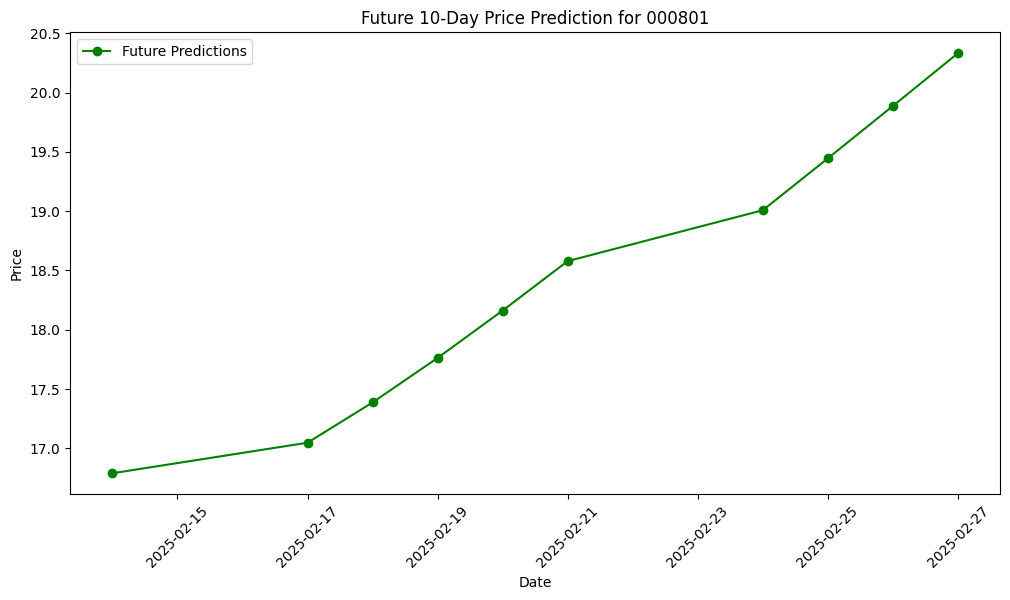

In [142]:
# 绘制未来10天的预测价格走势
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_prices, marker='o', linestyle='-', color='green', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f'Future 10-Day Price Prediction for {stock_code}')

# 保存图表到本地
output_path = f"temp_png/{stock_code}_10_day_price_prediction.png"  # 图片保存路径
plt.savefig(output_path, bbox_inches='tight', dpi=300)  # 保存为 PNG 文件
print(f"图表已保存到：{output_path}")
# 5️⃣ 插入图片到 Word 文档
doc.add_paragraph(f"{stock_code}预测走势图：")
doc.add_picture(output_path, width=Inches(8))  # 插入图片并调整宽度

plt.show()

In [143]:
# 6️⃣ 保存 Word 文档
doc.save(output_file)

print(f"✅ Word 文档已保存: {output_file}")

✅ Word 文档已保存: out_data/20250214_132738_lstm.docx
